In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys

In [3]:
import elfi

simulator:

In [4]:
sys.path.append('/Users/umvremes/multitasking-driving/model-infer')
import driver

In [5]:
import random

In [6]:
np.random.seed(123)
random.seed(123)

pretrain simulator models:

In [7]:
#params_grid=np.linspace(0,3,31)

In [8]:
#for sigma in params_grid:
#    for speed in [17,33]:
#        d = driver.driver(speed, sigma)
#        d.learn_transitions(iters = 200, debug = True)
#        d.softmax_temp = 1
#        d.learn_model(50000, anneal_softmax_temp_target = 0.1, debug = True)
#        np.save("driver-pre-{:.1f}-{}".format(sigma,speed), d.q)

test setup:

In [9]:
learn_transitions = 100
start_temp = 0.1
learn_time = 1000
target_temp = 0.001

In [10]:
max_pre=3

In [11]:
def driver_generator(sigma, batch_size = 1, random_state = None):
    data = []
    for speed in [17,33]:
        d = driver.driver(speed, sigma)
        d.learn_transitions(iters = learn_transitions)
        d.q = np.load("driver-pre-{:.1f}-{}.npy".format(np.minimum(sigma,max_pre),speed), allow_pickle=True).item()
        d.softmax_temp = start_temp
        d.learn_model(learn_time, anneal_softmax_temp_target = target_temp)
        d_learning = False
        d.log_p = True
        d.log_as_array = True
        d.softmax_temp = target_temp
        d.clear()    
        d.learn_model(300)
        data.append(d.log)
    return data

sum stats:

In [12]:
def offset_std_60(data):
    return np.std(data[:,0],axis=1)

def offset_std_120(data):
    return np.std(data[:,1],axis=1)

load observations:

In [13]:
observed_ss=[0.168, 0.247]

elfi model:

In [14]:
import scipy.stats as ss

In [15]:
m=elfi.new_model()
sigma = elfi.Prior(ss.gamma, 3, 0, 0.5, model=m)
Y = elfi.Simulator(elfi.tools.vectorize(driver_generator), sigma)
S1 = elfi.Summary(offset_std_60, Y, observed=observed_ss[0])
S2 = elfi.Summary(offset_std_120, Y, observed=observed_ss[1])
d = elfi.Distance('euclidean', S1, S2)
log_d = elfi.Operation(np.log, d)

BOLFI:

In [16]:
bounds={'sigma':(0,3)}

In [17]:
import GPy

In [18]:
span=3
kernel = GPy.kern.RBF(input_dim=1,ARD=True)
kernel.lengthscale=span/5
kernel.lengthscale.set_prior(GPy.priors.Gamma(2,10/span), warning=False)
kernel=kernel+GPy.kern.Bias(input_dim=1)

In [19]:
target_model=elfi.GPyRegression(m.parameter_names,bounds=bounds,kernel=kernel)

In [20]:
bolfi = elfi.BOLFI(log_d, batch_size=1, initial_evidence=20, update_interval=10, bounds=bounds, target_model=target_model)

In [21]:
%time post=bolfi.fit(n_evidence=100)

Progress: |██████████████████████████████████████████████████| 100.0% Complete
CPU times: user 49min 57s, sys: 30 s, total: 50min 27s
Wall time: 52min 40s


In [22]:
bolfi.target_model._gp

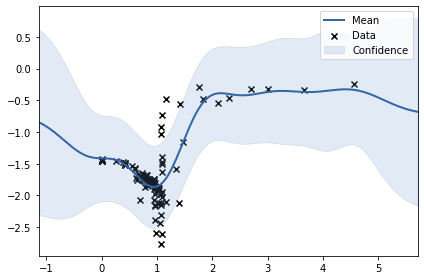

In [23]:
bolfi.target_model._gp.plot();

sample:

In [24]:
%time sample_1=bolfi.sample(1000)

NUTS: Diverged proposals after warmup (i.e. n_adapt=500 steps): 1


4 chains of 1000 iterations acquired. Effective sample size and Rhat for each parameter:
sigma 1860.3506715681854 1.0020471883578874
CPU times: user 1min 58s, sys: 11 s, total: 2min 9s
Wall time: 1min 6s


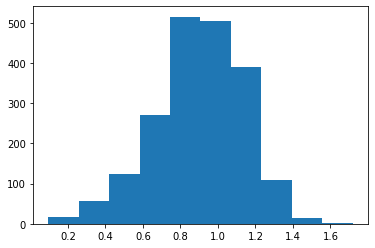

In [25]:
plt.hist(sample_1.outputs[m.parameter_names[0]]);

In [26]:
np.mean(sample_1.outputs[m.parameter_names[0]])

0.9021525751158037